In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt


In [2]:
!mkdir -p ../external && wget --output-document="../external/tiles3.py" http://incompleteideas.net/tiles/tiles3.py-remove

--2019-06-23 10:32:58--  http://incompleteideas.net/tiles/tiles3.py-remove
Resolving incompleteideas.net (incompleteideas.net)... 208.113.171.177
Connecting to incompleteideas.net (incompleteideas.net)|208.113.171.177|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3966 (3,9K)
Saving to: ‘../external/tiles3.py’

../external/tiles3. 100%[===================>]   3,87K  --.-KB/s    in 0s      

2019-06-23 10:32:58 (169 MB/s) - ‘../external/tiles3.py’ saved [3966/3966]



In [3]:
sys.path.append('../external')
from tiles3 import tiles, IHT

class TilingModel:
    def __init__(self, weights, numTilings=8, alpha=0.1, scaleFactorX=10, scaleFactorY=10):
        self.weights = weights
        self.iht = IHT(len(self.weights))
        self.numTilings = numTilings
        self.stepSize = alpha/self.numTilings
        self.scaleFactorX = scaleFactorX
        self.scaleFactorY = scaleFactorY

    def mytiles(self, x, y):
        return tiles(self.iht, self.numTilings, [x*self.scaleFactorX,y*self.scaleFactorY])

    def learn(self, x, y, z):
        tiles = self.mytiles(x, y)
        estimate = 0
        for tile in tiles:
            estimate += self.weights[tile]                  #form estimate
        error = z - estimate
        for tile in tiles:
            self.weights[tile] += self.stepSize * error     #learn weights

    def test(self, x, y):
        tiles = self.mytiles(x, y)
        estimate = 0
        for tile in tiles:
            estimate += self.weights[tile]
        return estimate

In [4]:
sys.path.append('..')
import SeqGen
import SARSAn
import MountainCarSetup as mc

actions_dim = 3

class getActionValues:
    def __init__(self, models):
        self.models = models

    def __getitem__(self, state):
        return [m.test(state[0],state[1]) for m in models]

w = (np.random.rand(actions_dim, 4096) - 0.5) * 0.001
models = [TilingModel(w[i],numTilings=16,scaleFactorX=10,scaleFactorY=20) for i in range(actions_dim)]

# Need for SeqGen.EpsilonGreedyPolicy
q_s_a_func = getActionValues(models)

def getStateTransition(s,a):
    p,v,f,r = mc.getTransition(s[0], s[1], a-1.0)
    return (f, (p,v), r)

In [5]:
sequence = SeqGen.SequenceGeneratorPlus(SeqGen.EpsilonGreedyPolicy(q_s_a_func, 0.1), 
                                  mc.getStartPosition,
                                  getStateTransition,
                                  12
                                 )

In [6]:
SARSAn.SARSAn(sequence,
       lambda s,a: models[a].test(s[0],s[1]),
       lambda s,a,t: models[a].learn(s[0],s[1],t),
       n=12,
       gamma=0.99
      )

Episode length is     157
Sequence terminated.

Finished.


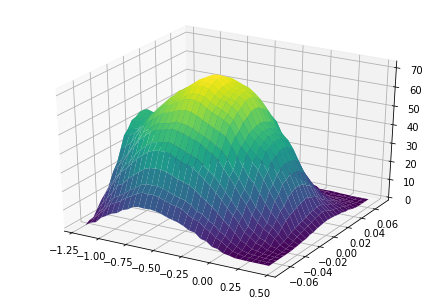

In [7]:
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

X = np.arange(-1.2, 0.5, 0.05)
Y = np.arange(-0.07, 0.07, 0.005)
X, Y = np.meshgrid(X, Y)

it = zip(X.ravel(), Y.ravel())

Z = np.array([-np.max(q_s_a_func[s]) for s in it]).reshape(X.shape)

fig = plt.figure()
ax = Axes3D(fig)
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.viridis)

plt.show()

In [25]:
q_s_a_func[(0.1,0.01)]

[0.0005252633331242504, -0.00018477946663500482, -0.00043087421037948134]

In [91]:
models[0].learn(0.1,0.01, 0.1)
models[0].test(0.1,0.01)

0.09975479132184958